In [1]:
from jax import random
from jax import numpy as jnp

import numpyro
from numpyro import sample
from numpyro import param
from numpyro import deterministic
from numpyro import plate
from numpyro.optim import Adam
from numpyro.infer import Trace_ELBO
from numpyro.infer import SVI
from numpyro.infer.autoguide import AutoDelta
from numpyro.distributions import Normal


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

# color blind friendly palette
cp = ['#39436F', '#A12E4A', '#ABAF31', '#31AEB5', '#D0D0D0']
# https://davidmathlogic.com/colorblind/#%2339436F-%23A12E4A-%23ABAF31-%2331AEB5-%23D0D0D0

mpl_style_main = {
    'figure.dpi': 72,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Open Sans', 'Arial'],
    'axes.prop_cycle': cycler(color=cp[:-1]),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.xmargin': 0,
    'figure.autolayout': True,
    'lines.linewidth': 1,
}
plt.rcParams.update(mpl_style_main)


# Basic Example


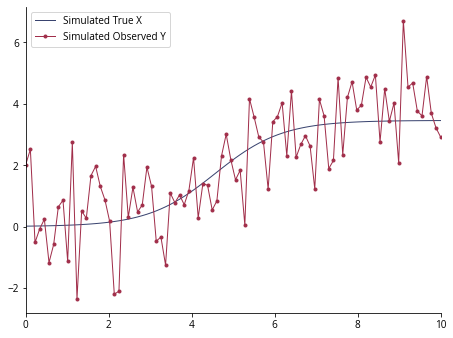

In [3]:
# simulating experimental data

N = 90 # number of time samples

rkey = random.key(0) # random seed

# (maybe you actually want to replace this with something causal?)
def sigmoid(t, a, b, c):
    return a / (1 + jnp.exp(-(t-c)*b))

# arbitrary true values
a_true = 3.456
b_true = 1.234
c_true = 4.567

# evaluate response function at observation times
t_obs = jnp.linspace(0, 10, N)
x_true = sigmoid(t_obs, a_true, b_true, c_true)

# sample noisy observations
sigma_y_true = 1.234
norm = Normal(x_true, sigma_y_true)
y_obs = norm.sample(rkey)

plt.plot(t_obs, x_true, '-', label='Simulated True X')
plt.plot(t_obs, y_obs, '.-', label='Simulated Observed Y')
plt.legend(loc='upper left')
plt.show()


In [4]:
# example sigmoid regression on data

# assert distributional parameters for priors
mu_a = 3.0
sigma_a = 0.3

mu_b = 1.0
sigma_b = 0.1

mu_c = 4.0
sigma_c = 0.4

# initial guess for freely varying parameter
sigma_y_init = 1.0

def model(t_obs, y_obs):
    a = sample('a', Normal(mu_a, sigma_a))
    b = sample('b', Normal(mu_b, sigma_b))
    c = sample('c', Normal(mu_c, sigma_c))
    x = deterministic('x', sigmoid(t_obs, a, b, c))
    sigma_y = param('sigma_y', init_value=sigma_y_init)
    y = sample('y', Normal(x, sigma_y), obs=y_obs)


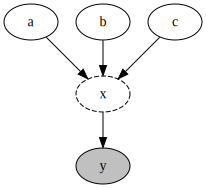

In [5]:
# visualize the model
# note -- this requires pip install graphviz

# (what you specify for these kwargs doesn't really matter
# (just need arrays with the right shapes to trace the model)

kwargs = {
    't_obs': t_obs,
    'y_obs': y_obs,
}
numpyro.render_model(model, model_kwargs=kwargs)


In [6]:
# compute MAP for observed data

rkey1, rkey2 = random.split(rkey, 2) # new random seeds

# optimization parameters
step_size = 0.01
num_steps = 1000

auto_guide = AutoDelta(model)
optimizer = Adam(step_size=step_size)
loss = Trace_ELBO()
svi = SVI(model, auto_guide, optimizer, loss=loss)

svi_result = svi.run(rkey1, num_steps, progress_bar=True, **kwargs)
map_params = svi_result.params
map_sample = auto_guide.sample_posterior(rkey2, map_params, **kwargs)


100%|████| 1000/1000 [00:00<00:00, 2458.05it/s, init loss: 151.0910, avg. loss [951-1000]: 142.9269]


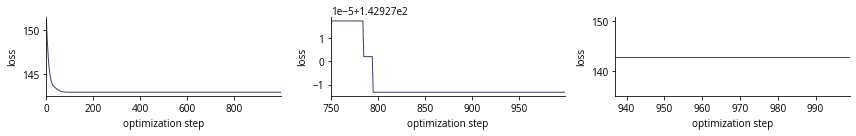

In [7]:
# Visualize loss curve -- check for stability

losses = svi_result.losses
num_steps = losses.size
idx = jnp.arange(num_steps)
plt.figure(figsize=(12,2))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(idx[-num_steps//4**k:], losses[-num_steps//4**k:])
    plt.xlabel('optimization step')
    plt.ylabel('loss')
plt.show()


MAP a  = 3.5010679
True a = 3.456

MAP b  = 1.0118886
True b = 1.234

MAP c  = 4.4793434
True c = 4.567

MAP sigma_y  = 1.1783277
True sigma_y = 1.234


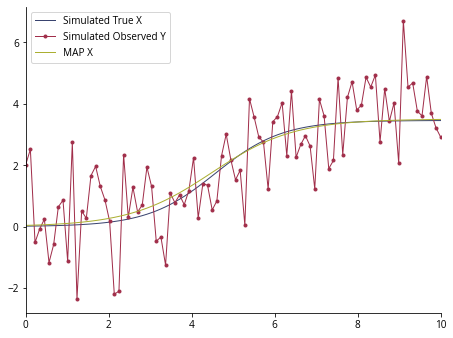

In [8]:
# extract MAP values
a_map = map_sample['a']
b_map = map_sample['b']
c_map = map_sample['c']
x_map = map_sample['x']

sigma_y_map = map_params['sigma_y']

print('MAP a  =', a_map)
print('True a =', a_true)
print()
print('MAP b  =', b_map)
print('True b =', b_true)
print()
print('MAP c  =', c_map)
print('True c =', c_true)
print()
print('MAP sigma_y  =', sigma_y_map)
print('True sigma_y =', sigma_y_true)

plt.plot(t_obs, x_true, '-', label='Simulated True X')
plt.plot(t_obs, y_obs, '.-', label='Simulated Observed Y')
plt.plot(t_obs, x_map, '-', label='MAP X')
plt.legend(loc='upper left')
plt.show()


# Partial observations


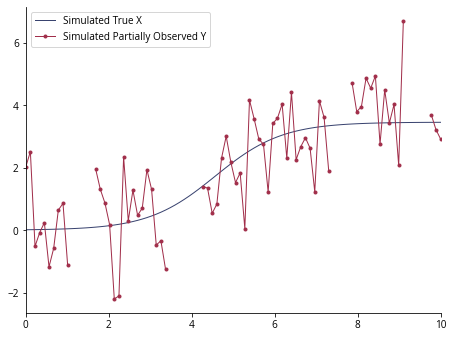

In [9]:
# create logical mask for observations (True = observed)

# NOTE: JAX arrays have a funny assignment notation
# numpy:     x[7] = 3.14
# jax.numpy: x = x.at[7].set(3.14)

y_mask = jnp.full_like(y_obs, True, dtype='bool')
y_mask = y_mask.at[10:15].set(False)
y_mask = y_mask.at[31:38].set(False)
y_mask = y_mask.at[66:70].set(False)
y_mask = y_mask.at[82:87].set(False)

# set nans in observations
y_obs_nans = y_obs.at[~y_mask].set(jnp.nan)

plt.plot(t_obs, x_true, '-', label='Simulated True X')
plt.plot(t_obs, y_obs_nans, '.-', label='Simulated Partially Observed Y')
plt.legend(loc='upper left')
plt.show()


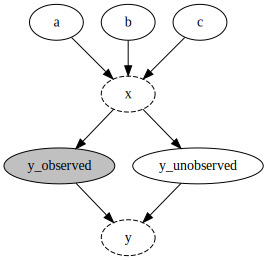

In [10]:
# modify model to accomodate partial observations

def model2(t_obs, y_obs, y_mask=None):
    a = sample('a', Normal(mu_a, sigma_a))
    b = sample('b', Normal(mu_b, sigma_b))
    c = sample('c', Normal(mu_c, sigma_c))
    x = deterministic('x', sigmoid(t_obs, a, b, c))
    sigma_y = param('sigma_y', init_value=sigma_y_init)
    y = sample('y', Normal(x, sigma_y), obs=y_obs, obs_mask=y_mask)

kwargs2 = {
    't_obs': t_obs,
    'y_obs': y_obs,
    'y_mask': y_mask,
}
numpyro.render_model(model2, model_kwargs=kwargs2)


100%|████| 1000/1000 [00:00<00:00, 2236.80it/s, init loss: 136.1875, avg. loss [951-1000]: 131.5045]


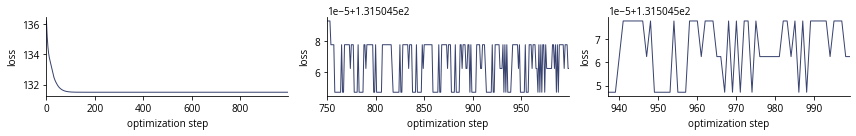

In [11]:
# compute MAP

rkey1, rkey2 = random.split(rkey, 2) # new random seeds

step_size = 0.01
num_steps = 1000

auto_guide = AutoDelta(model2)
optimizer = Adam(step_size=step_size)
loss = Trace_ELBO()
svi = SVI(model2, auto_guide, optimizer, loss=loss)

svi_result = svi.run(rkey1, num_steps, progress_bar=True, **kwargs2)
map_params = svi_result.params
map_sample = auto_guide.sample_posterior(rkey2, map_params, **kwargs2)

losses = svi_result.losses
num_steps = losses.size
idx = jnp.arange(num_steps)
plt.figure(figsize=(12,2))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(idx[-num_steps//4**k:], losses[-num_steps//4**k:])
    plt.xlabel('optimization step')
    plt.ylabel('loss')
plt.show()


MAP a  = 3.4445543
True a = 3.456

MAP b  = 1.0198078
True b = 1.234

MAP c  = 4.46552
True c = 4.567

MAP sigma_y  = 1.0416365
True sigma_y = 1.234


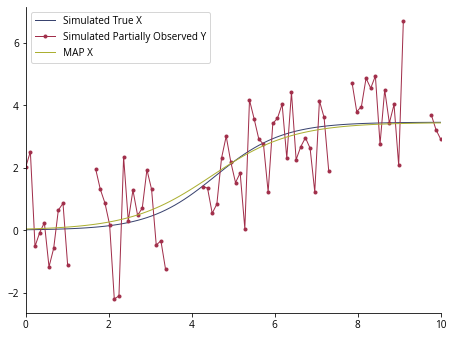

In [12]:
a_map = map_sample['a']
b_map = map_sample['b']
c_map = map_sample['c']
x_map = map_sample['x']

sigma_y_map = map_params['sigma_y']

print('MAP a  =', a_map)
print('True a =', a_true)
print()
print('MAP b  =', b_map)
print('True b =', b_true)
print()
print('MAP c  =', c_map)
print('True c =', c_true)
print()
print('MAP sigma_y  =', sigma_y_map)
print('True sigma_y =', sigma_y_true)

plt.plot(t_obs, x_true, '-', label='Simulated True X')
plt.plot(t_obs, y_obs_nans, '.-', label='Simulated Partially Observed Y')
plt.plot(t_obs, x_map, '-', label='MAP X')
plt.legend(loc='upper left')
plt.show()


# Multivariate data


In [ ]:
# simulating experimental data
# observations have shape (M x K x N) = (people x signals x samples)

rkey_a, rkey_b, rkey_c = random.split(rkey, 3)

M = 7 # number of people
K = 3 # number of signals
N = 90 # number of time samples

# sample separate parameters for each person
a_true = Normal(mu_a, sigma_a).sample(rkey_a, sample_shape=(M,1,1))
b_true = Normal(mu_b, sigma_b).sample(rkey_b, sample_shape=(M,1,1))
c_true = Normal(mu_c, sigma_c).sample(rkey_c, sample_shape=(M,1,1))

# evaluate response function at observation times
t_obs = jnp.linspace(0, 10, N)[None,None,:]
x_true = sigmoid(t_obs, a_true, b_true, c_true)

# sample noisy observations
sigma_y_true = 1.234
norm = Normal(x_true, jnp.full((1, K, 1), sigma_y_true))
y_obs = norm.sample(rkey)

print('different X for each person')
plt.plot(t_obs[:,0,:].T, x_true[:,0,:].T, '-')
plt.show()

print('for one person, multiple noisy signals')
plt.plot(t_obs[0,:,:].T, y_obs[0,:,:].T, '-')
plt.show()



In [ ]:
# modify model to accomodate multivariate data

def model3(t_obs, y_obs):
    sigma_y = param('sigma_y', init_value=sigma_y_init)
    with plate('person', M, dim=-3):    
        a = sample('a', Normal(mu_a, sigma_a))
        b = sample('b', Normal(mu_b, sigma_b))
        c = sample('c', Normal(mu_c, sigma_c))
        x = deterministic('x', sigmoid(t_obs, a, b, c))
        with plate('signal', K, dim=-2):
            with plate('sample', N, dim=-1):
                y = sample('y', Normal(x, sigma_y), obs=y_obs)
    
kwargs3 = {
    't_obs': t_obs,
    'y_obs': y_obs,
}
numpyro.render_model(model3, model_kwargs=kwargs3)


In [ ]:
# compute MAP

rkey1, rkey2 = random.split(rkey, 2) # new random seeds

step_size = 0.01
num_steps = 1000

auto_guide = AutoDelta(model3)
optimizer = Adam(step_size=step_size)
loss = Trace_ELBO()
svi = SVI(model3, auto_guide, optimizer, loss=loss)

svi_result = svi.run(rkey1, num_steps, progress_bar=True, **kwargs3)
map_params = svi_result.params
map_sample = auto_guide.sample_posterior(rkey2, map_params, **kwargs3)

losses = svi_result.losses
num_steps = losses.size
idx = jnp.arange(num_steps)
plt.figure(figsize=(12,2))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(idx[-num_steps//4**k:], losses[-num_steps//4**k:])
    plt.xlabel('optimization step')
    plt.ylabel('loss')
plt.show()


In [ ]:
x_map = map_sample['x']

print('different X for each person')
for i in range(M):
    print('person', i+1)
    plt.figure(figsize=(5,3))
    plt.plot(t_obs[i,0,:].T, x_true[i,0,:].T, '-', c=cp[0], label='True X')
    plt.plot(t_obs[i,0,:].T, x_map[i,0,:].T, '-', c=cp[2], label='MAP x')
    plt.legend(loc='upper left')
    plt.show()
